<a href="https://colab.research.google.com/github/01-Projects-In-Python/Project-Shopee-business-case/blob/main/Code-Project_Shopee_business_case.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project overview:

__Introduction:__

In response to the challenge faced by online businesses like Shopee, the task is to identify near-duplicate products within a large dataset. This task becomes more complex due to the diverse user-generated content, including images and product descriptions. The goal of this competition is to develop a machine learning model that can accurately identify products that have been posted repeatedly, even when they may have subtle differences in images, titles, or descriptions.

__Data Description:__

The dataset contains metadata and images of products posted on Shopee's platform. Each row contains the data for a single posting. __Multiple postings might have the exact same image ID, but with different titles or vice versa__. Each entry includes the following information:

| Variable | Description|
| --- | --- |
| posting_id | the ID code for the posting.
| image | the image id/md5sum.
| image_phash | a perceptual hash of the image.
| title | the product description for the posting.
| label_group | ID code for all postings that map to the same product. Not provided for the test set.

[Link: Shopee's business case](https://www.kaggle.com/competitions/shopee-product-matching/data)

__Loading the libraries and the dataset based on the Link provided:__

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from IPython.display import display, Image
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import shutil
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
#!pip install kaggle
#!pip install pyLDAvis
#!pip install googletrans==4.0.0rc1

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download shopee-product-matching

mkdir: cannot create directory ‘/root/.kaggle’: File exists
shopee-product-matching.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip shopee-product-matching.zip

Archive:  shopee-product-matching.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Task 1: Data Exploration and Preprocessing

### a. Conduct an initial exploration of the dataset. Analyze the distribution of product categories, image properties, and textual descriptions.

In [ ]:
# Reading the train dataset
df = pd.read_csv('train.csv')

In [ ]:
df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [ ]:
df.shape

(34250, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34250 entries, 0 to 34249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   posting_id   34250 non-null  object
 1   image        34250 non-null  object
 2   image_phash  34250 non-null  object
 3   title        34250 non-null  object
 4   label_group  34250 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.3+ MB


**Interpretation:

The training dataset comprises 34250 observations and encompasses 5 variables. Among these, 4 variables are categorical, while 1 variable is numerical. The numerical variable, which serves as an identifier for postings associated with a specific product, will be converted into a categorical format.

In [ ]:
df['label_group'] = df['label_group'].astype('category')
df['image_phash'] = df['image_phash'].astype('category')

In [ ]:
df_null = df.isnull().sum()
print(df_null[df_null > 0])

Series([], dtype: int64)


__--> Analyzing the distribution of products' categories:__

In [ ]:
u_labels = df['label_group'].nunique()
print('Number of unique categories', u_labels)

Number of unique categories 11014


In [ ]:
# count number of duplicate rows
d_label = df['label_group'].duplicated().sum()
print('Number of duplicate categories:', d_label)

Number of duplicate categories: 23236


Text(0.5, 1.0, 'Top 20 repeated categories')

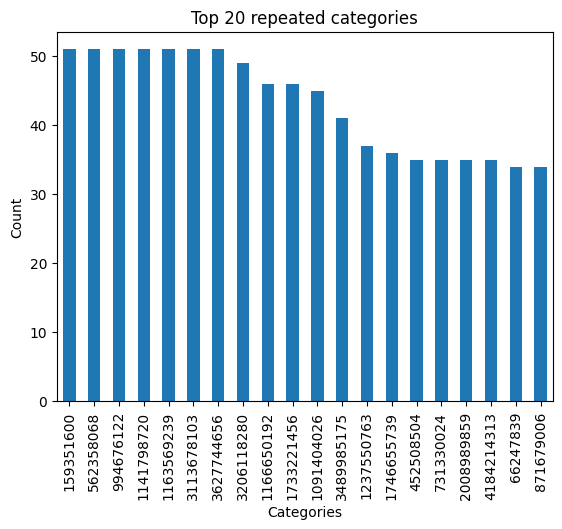

In [ ]:
d_label_detail = df.pivot_table(index = ['label_group'], aggfunc ='size').nlargest(20)
d_label_detail.plot(kind = 'bar')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Top 20 repeated categories')

In [ ]:
df.pivot_table(index = ['label_group'], aggfunc ='size').nsmallest(5)

label_group
297977     2
801176     2
887886     2
942089     2
3108272    2
dtype: int64

In [ ]:
dup_cat2 = sum(df.groupby('label_group')['label_group'].count() == 1)
print("Total count of repeated categories 2 times:", dup_cat2)

Total count of repeated categories 2 times: 0


In [ ]:
mean_cat = df.groupby('label_group')['label_group'].count().mean()
print("Average observation per category:", round(mean_cat,0))

Average observation per category: 3.0


**Interpretation:

Within this dataset, there exist 11,014 distinctive categories that give rise to a column of 23,236 duplicated labels, resulting in a total of 34,250 observations. Among the top 20 frequently recurring label groups, 7 clusters hold notable counts of 51 observations each (products). A noteworthy observation is that every category is duplicated at least twice, with a remarkable 6,979 categories following this trend. On average, each category seems to encompass around 3 products.

__--> Analyzing the distribution of the image properties:__

- Image analysis based on the file name:

In [ ]:
u_img = df['image'].nunique()
print('Number of unique images based on their name', u_img)

Number of unique images based on their name 32412


In [ ]:
d_image = df['image'].duplicated().sum()
print('Number of duplicate images based on their name:', d_image)

Number of duplicate images based on their name: 1838


Text(0.5, 1.0, 'Top 15 repeated images based on the name')

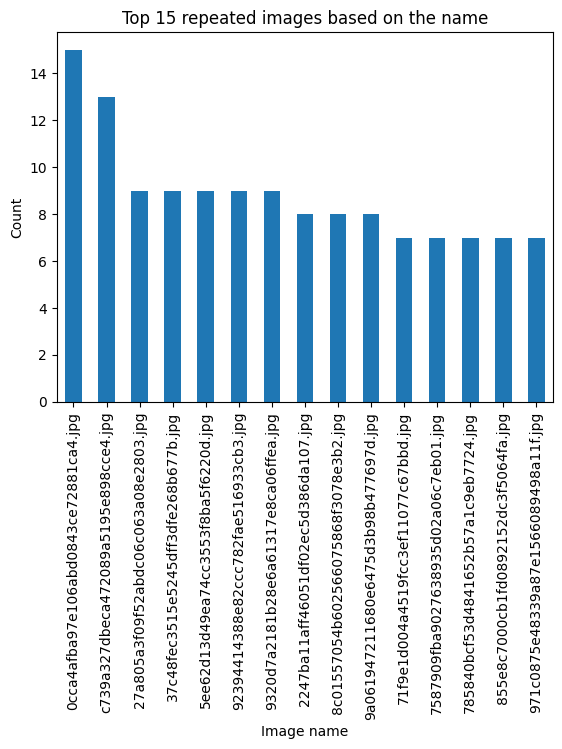

In [ ]:
d_image_detail = df.pivot_table(index = ['image'], aggfunc ='size').nlargest(15)
d_image_detail.plot(kind = 'bar')
plt.xlabel('Image name')
plt.ylabel('Count')
plt.title('Top 15 repeated images based on the name')

In [ ]:
df.pivot_table(index = ['image'], aggfunc ='size').nsmallest(5)

image
0000a68812bc7e98c42888dfb1c07da0.jpg    1
00039780dfc94d01db8676fe789ecd05.jpg    1
000a190fdd715a2a36faed16e2c65df7.jpg    1
00117e4fc239b1b641ff08340b429633.jpg    1
00136d1cf4edede0203f32f05f660588.jpg    1
dtype: int64

This dataset holds 32,412 individual images, and there are 1,838 images that appear more than once based on the image name. Our next focus is to understand how often the same image appears under the same label.

**Interpretation:

Analyzing `image` variable, we observe this dataset holds 32,412 unique images according to their name, and there are 1,838 images that appear more than once. The image named "0cca4afba97e106abd0843ce72881ca4.jpg" holds the record for the highest repetition, occurring 15 times within the dataset. Following closely, the image "c739a327dbeca472089a5195e898cce4.jpg" is found 13 times. Furthermore, there are 5 images that repeat 9 times, 3 images that repeat 8 times, and so forth, displaying a range of repetition frequencies.

- Image analysis based on the file name and the label_group variable:

In [ ]:
im_lab1 = sum((df.groupby('image')['image'].count() > 1) & (df.groupby('image')['label_group'].nunique() == 1))
print('Total duplicated images in one unique label_group:', im_lab1)

Total duplicated images in one unique label_group: 1200


In [ ]:
im_lab2 = sum((df.groupby('image')['image'].count() > 1) & (df.groupby('image')['label_group'].nunique() > 1))
print('Total duplicated images in more than one unique label_group:', im_lab2)

Total duplicated images in more than one unique label_group: 46


In [ ]:
im_lab3 = sum((df.groupby('image')['label_group'].nunique() == 2))
print('Total duplicated images in 2 label_groups:', im_lab3)

Total duplicated images in 2 label_groups: 44


In [ ]:
im_lab4 = sum((df.groupby('image')['label_group'].nunique() > 2))
print('Total duplicated images more than 2 label_groups:', im_lab4)

Total duplicated images more than 2 label_groups: 2


- Image analysis based on the images in the train_images folder:

In [ ]:
import os

In [ ]:
path = "/content/train_images"

In [ ]:
img_path = []

In [ ]:
# Collecting images
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
            image_path = os.path.join(root, file)
            img_path.append(image_path)

In [ ]:
print("Number of images:", len(img_path))
print("Example image path:", img_path[0])

Number of images: 32412
Example image path: /content/train_images/5741151ecc3cac47817598996c75b952.jpg


In [ ]:
dup_img = {x for x in img_path if img_path.count(x) > 1}
print('Duplicated images based on their name:', len(dup_img))

Duplicated images based on their name: 0


In [ ]:
# Validating the difference size of our image dataset
image_sizes = []
for root, dirs, files in os.walk(path):
    for x in files:
        file_path = os.path.join(root, x)
        image_size = os.path.getsize(file_path)
        image_sizes.append(image_size)


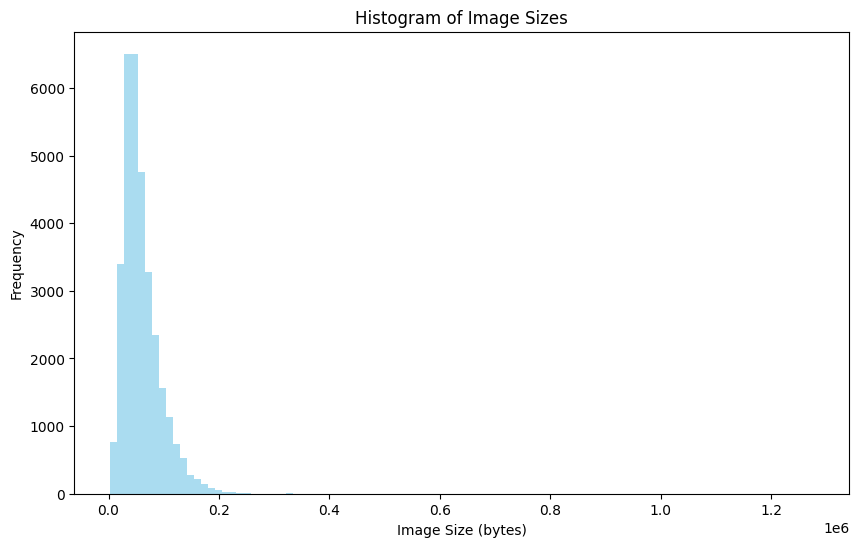

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(image_sizes, bins=100, color='skyblue', alpha=0.7)
plt.title('Histogram of Image Sizes')
plt.xlabel('Image Size (bytes)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
min_size = np.min(image_sizes)
min_size_mb = min_size / (1024 * 1024)

print('The minimum image size is:', round(min_size_mb, 4), 'MB')

The minimum image size is: 0.0019 MB


In [ ]:
max_size = np.max(image_sizes)
max_size_mb = max_size / (1024 * 1024)

print('The maximum image size is:', round(max_size_mb, 2), 'MB')

The maximum image size is: 1.22 MB


In [ ]:
mean_size = np.mean(image_sizes)
mean_size_mb = mean_size / (1024 * 1024)

print('The mean image size is:', round(mean_size_mb, 2), 'MB')

The mean image size is: 0.06 MB


**Interpretation:

The folder labeled "train_image" comprises a total of 32,412 images. It is noteworthy that upon inspection of the image names, there are no instances of duplicated values. This observation corroborates the findings from the "Analyzing the distribution of the image properties" section, where our investigation revealed that the count of distinct images within our "image" variable stands at 32,412.

On a different note, an examination of the image dimensions within the "train_image" directory indicates considerable diversity in their sizes. Specifically, the sizes span a range from 0.0019 MB to 1.22 MB. Notably, over 6,000 images exhibit dimensions that yield an average image size of 0.06 MB.

__--> Analyzing the text description:__

In [ ]:
# Verifying the length of the 'Title' variable
df['title_len'] = df['title'].apply(len)
df.head()

,posting_id,image,image_phash,title,label_group,title_len
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,25
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,60
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,43
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,98
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,33


<Axes: ylabel='Frequency'>

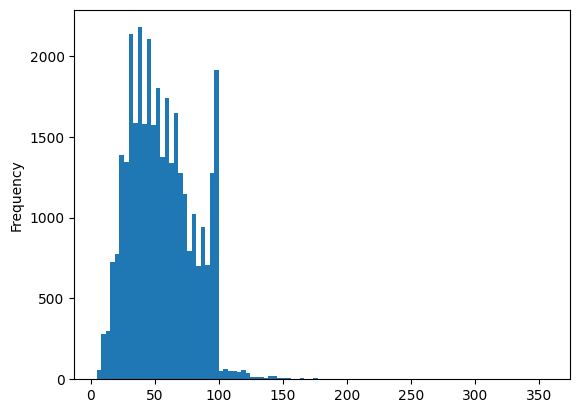

In [ ]:
df['title_len'].plot(bins=100, kind='hist')

In [ ]:
df['title_len'].describe()

count    34250.000000
mean        56.163474
std         25.100492
min          5.000000
25%         36.000000
50%         53.000000
75%         73.000000
max        357.000000
Name: title_len, dtype: float64

In [ ]:
# Let's see the longest title 357
df[df['title_len'] == 357]['title'].iloc[0]

'Mukena Bali Polos Rayon Janger Jumbo rample Adem Premium \\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80\\xe3\\x80\\x80 #produkbali'

In [ ]:
# Let's see the shortest title 5
df[df['title_len'] == 5]['title'].iloc[0]

'fullo'

In [ ]:
# Let's see the message with mean length
df[df['title_len'] == 56]['title'].iloc[0]

'HnKfashion Sweater Hoodie WHO Printing BabyTerry - Fit L'

### b. Preprocess the data, including text and image data, to ensure consistency and quality. Describe the preprocessing steps taken and their impact on the data.

__--> Preprocessing text data:__

During the validation of the lenght of the `title` variable we could see that are some words in our dataset that are not in English so to ensure accurate and efficient data analysis on the text data, we should perform the following preprocessing the data:

- Translating the words that are in another language to English
- Eliminating punctuation marks.
- Excluding stopwords.

Failing to translate the words to English, remove punctuation and stopwords could adversely affect the accuracy of the analysis, introducing unnecessary noise and potentially impacting memory and storage efficiency during Feature Engineering and Representation. To optimize accuracy and efficiency, we will apply a function named data_cleaning to remove punctuation marks and stopwords from this column.

- Translating the words that are in another language to English

In [ ]:
# Transforming the words to lower case to translation
df['title'] = df['title'].str.lower()

In [ ]:
df.head()

,posting_id,image,image_phash,title,label_group,title_len
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,paper bag victoria secret,249114794,25
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"double tape 3m vhb 12 mm x 4,5 m original / do...",2937985045,60
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,maling tts canned pork luncheon meat 397 gr,2395904891,43
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,daster batik lengan pendek - motif acak / camp...,4093212188,98
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,nescafe \xc3\x89clair latte 220ml,3648931069,33


In [ ]:
df['title'] = df['title'].apply(lambda x: [word.strip() for word in x.split()])

In [ ]:
df.head()

,posting_id,image,image_phash,title,label_group,title_len
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,"[paper, bag, victoria, secret]",249114794,25
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"[double, tape, 3m, vhb, 12, mm, x, 4,5, m, ori...",2937985045,60
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,"[maling, tts, canned, pork, luncheon, meat, 39...",2395904891,43
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,"[daster, batik, lengan, pendek, -, motif, acak...",4093212188,98
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,"[nescafe, \xc3\x89clair, latte, 220ml]",3648931069,33


In [ ]:
import nltk

In [ ]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [ ]:
from nltk.corpus import words

In [ ]:
def translate_non_english_words2(title2):
    from googletrans import Translator
    english_word_list = words.words()

    translator = Translator()
    translated_words2 = []

    for i in title2:
      if i.isalpha() and i not in english_word_list:
          translation2 = translator.translate(i, dest='en')
          translated_words2.append(translation2.text)
      else:
          translated_words2.append(i)

    return translated_words2

In [ ]:
# df['title_translated'] = df['title'].apply(translate_non_english_words2)
# Elapsed Time: 3 hours and 20 minutes - Outcome: Unsuccessful

Despite our efforts to apply the earlier function for translating non-English words, the process wasn't successful due to limited computational resources. Even though we currently have access to the Hardware Acceleration A100 provided by Google Colab Pro, the translation process still encountered challenges.

- Eliminating punctuation marks and stopwords.


In [ ]:
df['title'] = df['title'].apply(lambda x: ' '.join(x))

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
def data_cleaning(title):
    Test_punc_removed = [w for w in title if w not in string.punctuation]
    Test_punc_removed_join = ''.join(Test_punc_removed)
    Test_punc_removed_join_clean = [word for word in Test_punc_removed_join.split()
                                    if word.lower() not in stopwords.words('english')]
    return Test_punc_removed_join_clean

In [ ]:
df['title'] = df['title'].apply(data_cleaning)

In [ ]:
df.head()

,posting_id,image,image_phash,title,label_group,title_len
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,"[paper, bag, victoria, secret]",249114794,25
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"[double, tape, 3m, vhb, 12, mm, x, 45, origina...",2937985045,60
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,"[maling, tts, canned, pork, luncheon, meat, 39...",2395904891,43
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,"[daster, batik, lengan, pendek, motif, acak, c...",4093212188,98
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,"[nescafe, xc3x89clair, latte, 220ml]",3648931069,33


__--> Preprocessing image data:__

To ensure accurate analysis of image data, we will implement a resizing process. This step is crucial owing to the diversity in byte counts across different images. Resizing optimizes memory and processing efficiency, enhances model performance, reduces storage requirements, and fosters uniform and equitable analysis. Consistent sizes streamline resource usage, elevate precision, and establish a shared foundation for the subsequent phase—Feature Engineering and Representation.

In [ ]:
output_folder = "/content/train_images_resized"

os.makedirs(output_folder, exist_ok=True)

target_size = (224, 224)

for root, dirs, files in os.walk(path):
    for filename in files:
        nimg_path_ = os.path.join(root, filename)

        img = Image.open(nimg_path_)
        img = img.resize(target_size)

        output_path = os.path.join(output_folder, filename)
        img.save(output_path)

**Interpretation:

In new folder was created with the resized images, now we have a total of  
 32,412 images with dimensions of 224 pixels in height and 224 pixels in width.

## Task 2: Feature Engineering and Representation

### a. Extract meaningful features from the text data (titles) to aid in product matching. Discuss the features you have selected and their relevance.

To distill significant insights from the textual data contained within the
`titles` variable, our approach involves two key steps. Firstly, we'll employ a WordCloud visualization to spotlight frequently recurring text patterns. Subsequently, we'll construct a model that identifies the most recurrent words, enhancing the accuracy of product matching processes. This multifaceted analysis will be seamlessly executed through the application of WordClud for text visualization and Gensim, an open-source Python library that specializes in natural language processing (NLP) and machine learning tasks involving text and language. It is designed to handle large-scale text data efficiently and provides various tools for working with textual content, such as topic modeling, word embedding, document similarity analysis, and more.

In [ ]:
import gensim
from gensim import corpora, models
from pprint import pprint
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud

__--> WordCloud:__

In [ ]:
# Converting the list of list of the Title column to an string
cleaned_titles = df['title'].apply(lambda x: ' '.join(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


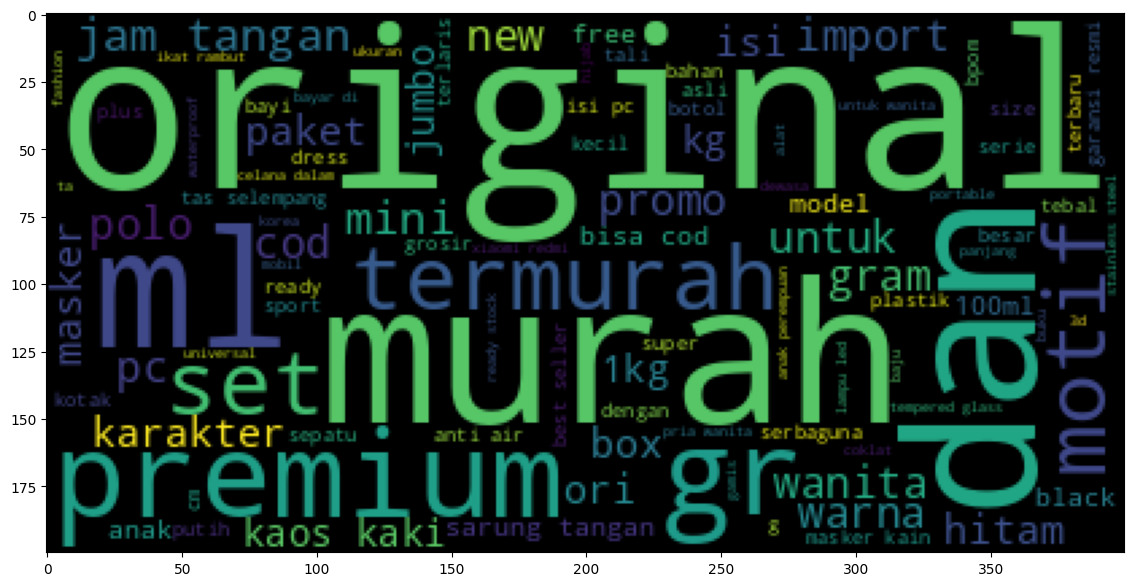

In [ ]:
wc = WordCloud(
    background_color='black',
    max_words = 100,
    random_state = 42,
    max_font_size=110
    )

wc.generate(' '.join(cleaned_titles))
plt.figure(figsize=(30,7))
plt.imshow(wc)
plt.show()

**Interpretation:

By examining the WordCloud plot, we're able to discern the prevailing terms with clarity. In this plot we can see some terms are not in English but in Indonesian as we mentioned earlier such as "Murah", "Termurah" and "untuk". Some of the most frequent words in English are "Original", "Premium", "Promo", "Set" among others.

__--> Model to identify the most recurrent words:__

In [ ]:
df['title_joined'] = df['title'].apply(lambda x: ' '.join(x))

In [ ]:
# Creating the documents
documents = df['title_joined'].tolist()
texts = [
    [word for word in document.lower().split() if word not in stopwords.words('english')]
    for document in documents
    ]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Creating the dictionary
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tfidf = models.TfidfModel(corpus)

corpus_tfidf = tfidf[corpus]
for doc in corpus_tfidf:
    print(doc)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
[(46, 0.11517245591198634), (554, 0.28662042596377457), (1436, 0.1935096016391195), (2062, 0.21339314341770976), (2501, 0.19682014959315033), (2823, 0.30418896026617376), (11097, 0.5463720314593469), (19808, 0.33765929860707783), (26135, 0.37269031628471433), (26136, 0.37269031628471433)]
[(91, 0.16039748140463936), (155, 0.20682479921448535), (162, 0.20085344042094613), (199, 0.16471682107425295), (245, 0.1398414417787699), (364, 0.2662118685524581), (379, 0.32683024141398526), (412, 0.23239284767469964), (784, 0.1954843996964478), (2057, 0.22076420171740335), (2571, 0.28528685072302146), (9237, 0.33829442799241705), (15968, 0.33829442799241705), (26137, 0.4642712289854562)]
[(39, 0.43274650729599373), (282, 0.41770717986383626), (284, 0.29200747256521853), (375, 0.4404430333582751), (899, 0.3662308093059855), (3788, 0.47420221104570626)]
[(1148, 0.28051578055643206), (2012, 0.5361864829750199), (2571, 0.39772799330999

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics= 20, id2word = dictionary, passes = 16, workers=8)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
top_topics = lda_model.top_topics(corpus_tfidf)
pprint(top_topics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[([(0.015950082, 'kaos'),
   (0.014054537, 'sepatu'),
   (0.012640802, 'pria'),
   (0.009807417, 'kaki'),
   (0.0063864673, 'panjang'),
   (0.0063240905, 'celana'),
   (0.0060665742, 'anak'),
   (0.0055526504, 'murah'),
   (0.005389957, 'pendek'),
   (0.005323252, 'sneakers'),
   (0.00515341, 'lampu'),
   (0.005052513, 'wanita'),
   (0.0050331242, 'polos'),
   (0.0046522524, 'casual'),
   (0.004378421, 'led'),
   (0.004369516, 'distro'),
   (0.0041756695, 'keset'),
   (0.004145827, 'lengan'),
   (0.004010731, 'adidas'),
   (0.0038546373, 'asi')],
  -9.971475539073262),
 ([(0.0066520562, 'baju'),
   (0.006284177, 'wanita'),
   (0.0059209988, 'bayi'),
   (0.005828864, 'set'),
   (0.005752283, 'sendok'),
   (0.005703206, 'bra'),
   (0.0055618873, 'gantungan'),
   (0.0050995643, 'rak'),
   (0.005051516, 'celana'),
   (0.004283319, 'hanger'),
   (0.0040774555, 'anak'),
   (0.0039037925, 'tempat'),
   (0.0038047584, 'makan'),
   (0.0037817515, 'tanpa'),
   (0.0036153535, 'legging'),
   (0.00

In [ ]:
# Exploring the words occuring in that topic and its relative weight
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic))
    print("\n")

Topic: 0 
Words: 0.010*"samsung" + 0.007*"kacamata" + 0.007*"galaxy" + 0.005*"tisu" + 0.004*"lotion" + 0.004*"tissue" + 0.004*"acnol" + 0.004*"koko" + 0.004*"garansi" + 0.004*"resmi"


Topic: 1 
Words: 0.013*"mukena" + 0.007*"topi" + 0.007*"anak" + 0.007*"cukur" + 0.006*"koko" + 0.006*"kucing" + 0.005*"sajadah" + 0.005*"pink" + 0.005*"unicorn" + 0.005*"katun"


Topic: 2 
Words: 0.013*"bluetooth" + 0.009*"headset" + 0.008*"speaker" + 0.008*"wireless" + 0.007*"earphone" + 0.006*"bass" + 0.005*"stereo" + 0.005*"jam" + 0.005*"audio" + 0.005*"salsa"


Topic: 3 
Words: 0.013*"sarung" + 0.012*"tangan" + 0.011*"jeans" + 0.010*"celana" + 0.005*"spray" + 0.005*"maycreate" + 0.005*"touch" + 0.004*"serut" + 0.004*"chino" + 0.004*"pria"


Topic: 4 
Words: 0.018*"tas" + 0.010*"selempang" + 0.008*"oppo" + 0.007*"wanita" + 0.007*"case" + 0.006*"xiaomi" + 0.006*"ransel" + 0.006*"implora" + 0.006*"redmi" + 0.005*"mobil"


Topic: 5 
Words: 0.008*"ml" + 0.006*"serum" + 0.006*"tunik" + 0.006*"botol" + 0.00

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus_tfidf, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
4     -0.152823 -0.165385       1        1  6.547198
15    -0.102008  0.093779       2        1  6.279251
6     -0.080109  0.012091       3        1  6.230174
5      0.137921 -0.013775       4        1  5.579012
18    -0.069009 -0.035810       5        1  5.463253
19     0.123906 -0.117743       6        1  5.437532
8     -0.055467 -0.124713       7        1  5.192868
12    -0.040634  0.068412       8        1  5.000367
2     -0.009092 -0.036148       9        1  4.879747
10     0.061605  0.004337      10        1  4.845656
9     -0.049375  0.049470      11        1  4.835678
11     0.130942 -0.035628      12        1  4.671763
14    -0.025831  0.066407      13        1  4.655260
13     0.012369  0.056491      14        1  4.533666
3     -0.025125  0.031245      15        1  4.518531
1      0.018168  0.055715      16        1  4.507248
16     0.030247  0.069107      17        1  4.413824
7      0.044907  0.059644      18        1  4.218707
0      0.041369 -0.060770      19        1  4.132750
17     0.008039  0.023274      20        1  4.057516, topic_info=          Term        Freq       Total Category  logprob  loglift
508        tas  184.000000  184.000000  Default  30.0000  30.0000
292       kaos  121.000000  121.000000  Default  29.0000  29.0000
278       mask  113.000000  113.000000  Default  28.0000  28.0000
197     masker  186.000000  186.000000  Default  27.0000  27.0000
955  bluetooth   64.000000   64.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
245          1   16.060325  193.990664  Topic20  -5.4384   0.7131
591     rambut   13.854630  121.276201  Topic20  -5.5861   1.0351
46        anak   12.834578  248.173124  Topic20  -5.6626   0.2426
91           2   11.022265  139.657344  Topic20  -5.8148   0.6653
509   termurah   10.388683  104.857400  Topic20  -5.8740   0.8927

[1245 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
1464      11  0.900064        09
245        1  0.056704         1
245        2  0.051549         1
245        3  0.041239         1
245        4  0.036084         1
...      ...       ...       ...
13860      2  0.920081  youtuber
1276       5  0.973121      yuja
16411     14  0.915890     zeera
12819      3  0.936489    zernii
5195       4  0.920500   zwitsal

[3981 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 16, 7, 6, 19, 20, 9, 13, 3, 11, 10, 12, 15, 14, 4, 2, 17, 8, 1, 18])

In [ ]:
cluster_words = []

for cluster in top_topics:
    words = [word_prob[1] for word_prob in cluster[0]]
    cluster_words.append(words)

In [ ]:
print('\nThe prevalent words within each cluster are:\n')
for cluster_id, words in enumerate(cluster_words):
    print(f"Cluster {cluster_id + 1} words: {words[0]}")


The prevalent words within each cluster are:

Cluster 1 words: kaos
Cluster 2 words: baju
Cluster 3 words: serum
Cluster 4 words: ml
Cluster 5 words: usb
Cluster 6 words: kuas
Cluster 7 words: cream
Cluster 8 words: rak
Cluster 9 words: rambut
Cluster 10 words: masker
Cluster 11 words: jilbab
Cluster 12 words: hand
Cluster 13 words: holder
Cluster 14 words: sarung
Cluster 15 words: mukena
Cluster 16 words: sponge
Cluster 17 words: bluetooth
Cluster 18 words: mask
Cluster 19 words: tas
Cluster 20 words: samsung


**Interpretation:

The provided code illustrates the dominant terms within each cluster, determined by their respective weights.

### b. Explore techniques for image feature extraction or representation, such as using pre-trained convolutional neural networks (CNNs).

To better understand how images can be broken down into meaningful features, we'll work with two ready-to-use models: ResNet50 and VGG16. These models are like expert image analyzers that can help us grasp the essential elements within images.

__--> ResNet50 Pretrained Model:__

- Model explanation:

ResNet50 is a type of deep learning model known as a convolutional neural network (CNN) that's particularly skilled at recognizing and categorizing images. The "50" in its name signifies that it has 50 layers, making it a deep architecture.

ResNet50 can dissect an image into different elements and recognize patterns, even in very deep networks, thanks to its smart shortcuts. This capability makes it a popular choice for various image-related tasks, from recognizing objects in pictures to classifying entire scenes.

- Model architecture:

ResNet50's architecture is designed to tackle the challenges of training very deep neural networks effectively. It introduces a concept called "residual learning" that enables the training of deeper networks without facing issues like vanishing gradients. Here's a simplified explanation of its architecture:

**Input Layer: This is where the raw image data is fed into the network.

**Convolutional Layers: These layers perform convolution operations to extract features from the input image. ResNet50 uses small filters (3x3) to scan the image and identify patterns.

**Residual Blocks: These are the key innovation in ResNet50. A residual block consists of several convolutional layers, but instead of directly outputting the result, it also stores the original input. The convolutional layers compute the difference between the input and output and add this difference back, effectively preserving the original information. This helps mitigate the vanishing gradient problem and allows deeper networks to be trained more effectively.

**Pooling Layers: These layers reduce the spatial dimensions of the feature maps, helping to extract higher-level features.

**Fully Connected Layers: These layers take the extracted features and combine them to make predictions. In classification tasks, these layers produce the final probabilities for each class.

[Link: Source ResNet50 info](https://datagen.tech/guides/computer-vision/resnet-50/#)

- Model application with a sample of train_images dataset:

In [ ]:
# Loading the required libraries:
from keras import utils
import numpy as np
import tensorflow as tf
from keras.applications import resnet

In [ ]:
path2 = "/content/train_images_resized"

In [ ]:
img_path2 = []

In [ ]:
# Collecting images
for root, dirs, files in os.walk(path2):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
            image_path2 = os.path.join(root, file)
            img_path2.append(image_path2)

In [ ]:
list_of_pics = list()
for x in img_path2[:1]:
    img = Image.open(x)
    list_of_pics.append(np.asarray(img))

In [ ]:
# Converting to Floating Point Values and Normalizing:
df_images = np.array(list_of_pics, dtype=np.float32)
df_images /= 255

In [ ]:
df_images.shape

(1, 224, 224, 3)

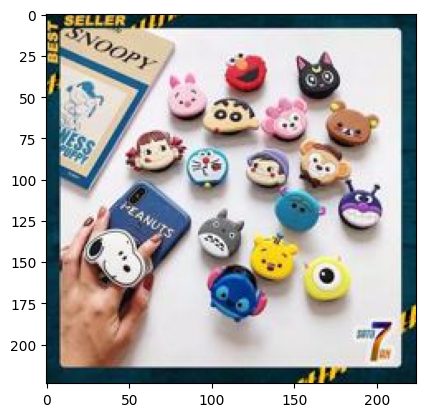

In [ ]:
img1 = df_images[0]

# Display the first image
plt.imshow(img1)
plt.show()

In [ ]:
# Load Keras' ResNet50 model that was pre-trained against the ImageNet database
model = resnet.ResNet50()

In [ ]:
# Scale the input image to the range used in the trained network
resnet_img = resnet.preprocess_input(df_images)

In [ ]:
predictions = model.predict(resnet_img)

1/1 [==============================] - 1s 1s/step


In [ ]:
predictions

array([[3.24619905e-05, 5.84002526e-04, 1.08917069e-04, 1.12938738e-04,
        2.37515575e-04, 8.14989908e-05, 9.51550755e-05, 2.21180569e-04,
        7.17590738e-05, 3.32920899e-04, 1.82444128e-04, 1.71728010e-04,
        1.16815143e-04, 1.13203365e-04, 1.97784066e-05, 1.92454696e-04,
        4.17111296e-05, 6.95848430e-05, 1.05498875e-04, 6.90764646e-05,
        2.65309995e-04, 2.33535058e-04, 2.92415760e-04, 9.37283985e-05,
        2.33737912e-04, 2.12565530e-04, 1.00664889e-04, 8.15516760e-05,
        4.10211505e-04, 4.27200343e-04, 9.49810492e-05, 9.68715583e-04,
        1.00919424e-04, 3.34339020e-05, 4.23081859e-04, 8.17695309e-06,
        9.86668820e-05, 1.34817092e-05, 1.55268714e-03, 1.03641520e-04,
        1.51025568e-04, 1.76019184e-05, 6.15075769e-05, 3.12699267e-05,
        1.21736244e-04, 6.58093632e-05, 1.76449612e-04, 1.84872813e-04,
        7.53365530e-05, 3.76300013e-05, 1.08059168e-04, 8.47915435e-05,
        2.30737365e-04, 4.69784194e-04, 3.71296192e-04, 5.587143

In [ ]:
# Look up the names of the predicted classes. Index zero is the results for the first image.
predicted_classes = resnet.decode_predictions(predictions, top=5)

In [ ]:
print("This is an image of:")

for imagenet_id, name, likelihood in predicted_classes[0]:
    print(" - {}: {:2f} likelihood".format(name, likelihood))

This is an image of:
 - television: 0.069138 likelihood
 - digital_clock: 0.056312 likelihood
 - monitor: 0.055306 likelihood
 - matchstick: 0.043921 likelihood
 - spotlight: 0.029090 likelihood


__--> VGG16 Pretrained Model:__

- Model explanation and architecture:

VGG16, short for Visual Geometry Group 16, is a convolutional neural network (CNN) architecture widely used for image classification and feature extraction tasks. The "16" in its name refers to the total number of weight layers in the network.

VGG16 is known for its simplicity and effectiveness. It follows a uniform architecture where the convolutional layers use small filters (3x3) and are stacked on top of each other, followed by max-pooling layers to reduce spatial dimensions. The key feature of VGG16 is its depth, achieved by stacking multiple convolutional layers. This depth allows it to capture intricate patterns and features in images.

- Model architecture:

**Convolutional Layers: VGG16 has 13 convolutional layers with 3x3 filters, and each layer is followed by a Rectified Linear Unit (ReLU) activation function. These layers perform feature extraction by scanning the image with filters to detect various visual features.

**Max-Pooling Layers: After every two or three convolutional layers, max-pooling layers are applied to downsample the spatial dimensions, reducing the computational load and capturing more abstract features.

**Fully Connected Layers: VGG16 ends with a few fully connected layers, also known as dense layers. These layers combine the extracted features and make final predictions. In the original VGG16, there are three fully connected layers, and the last one produces the output probabilities for various classes in classification tasks.

**Number of Filters: The depth of VGG16 is achieved by increasing the number of filters in each layer. Deeper layers have more filters, allowing the network to learn complex features.

VGG16 has been pretrained on large image datasets like ImageNet, making it capable of extracting useful hierarchical features from images. While it's an older architecture, it still serves as a strong baseline for image-related tasks and has inspired the development of more advanced networks.

[Link: Source VGG16](https://datagen.tech/guides/computer-vision/vgg16/)

- Model application with a sample of train_images dataset:

In [ ]:
from keras.applications import VGG16
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [ ]:
# Load Keras' VGG16 model that was pre-trained against the ImageNet database
model_vgg = VGG16()

In [ ]:
# Scale the input image to the range used in the trained network
vgg_img = preprocess_input(df_images)

In [ ]:
predictions_vgg = model.predict(vgg_img)

1/1 [==============================] - 0s 28ms/step


In [ ]:
predictions_vgg

array([[7.22695131e-06, 1.58369308e-04, 4.24246900e-06, 5.19966216e-06,
        2.25997264e-05, 2.14926822e-05, 1.52782995e-05, 4.60170813e-05,
        6.30157137e-06, 3.15766265e-05, 1.10397496e-05, 1.06162161e-05,
        1.33097510e-05, 9.13205531e-06, 1.62560286e-06, 2.38146094e-05,
        6.79056257e-06, 1.16112633e-05, 1.74638990e-05, 4.72505008e-06,
        1.57610139e-05, 1.08417817e-05, 2.48705874e-05, 1.33372341e-05,
        1.42289537e-05, 3.02482658e-05, 1.54616246e-05, 3.14478493e-05,
        1.71869484e-04, 2.32613493e-05, 1.18623148e-05, 9.94841394e-05,
        2.06604036e-05, 3.02038825e-06, 1.86983991e-04, 1.26794077e-06,
        1.17990749e-05, 1.30497097e-06, 1.02798501e-03, 2.64821465e-05,
        1.90896462e-05, 7.04929289e-06, 7.01917907e-06, 5.45574039e-06,
        1.81641881e-05, 1.19949236e-05, 2.76951760e-05, 1.72999717e-05,
        4.18837453e-06, 1.26109217e-06, 1.23034624e-05, 1.28128813e-05,
        8.36917170e-05, 5.66609488e-05, 3.13677265e-05, 7.220237

In [ ]:
# Look up the names of the predicted classes. Index zero is the results for the first image.
predictedvgg_classes = decode_predictions(predictions_vgg, top=5)

In [ ]:
print("This is an image of:")

for imagenet_id, name, likelihood in predictedvgg_classes[0]:
    print(" - {}: {:2f} likelihood".format(name, likelihood))

This is an image of:
 - digital_clock: 0.390082 likelihood
 - nematode: 0.052684 likelihood
 - spotlight: 0.045750 likelihood
 - bubble: 0.041666 likelihood
 - matchstick: 0.038384 likelihood


### c. Combine text and image features to create a comprehensive representation for each product.

To seamlessly integrate text and image features and construct comprehensive representations for each product, we will generate a dataset that encompasses all the images stored within the train_image folder. This dataset will encompass the paths of each image. Subsequently, we will merge the df_eng dataset with this newly created image dataset through concatenation.

In [ ]:
names = os.listdir('/content/train_images_resized')
names

['5741151ecc3cac47817598996c75b952.jpg',
 '49046a0e7e87ac78eb34a0102cfe4eeb.jpg',
 'aa1b550b4cc3ab2c9be2205a870eaf5d.npz',
 'b54746ec598a5ed56b9740480726c792.jpg',
 '18186ab5bc28663d82fbb35c059aab74.jpg',
 '4edcfc239c17445eb949103c9f13eed3.jpg',
 '1cf10c608685c44410ace582e42290f0.jpg',
 '14370e9185c8f953e06d12b2b51018b0.jpg',
 'de7b63254b5ae7202840c5d40f5ae2e8.jpg',
 '022d0f0e3629230be3fb5af47a88cb48.jpg',
 '98e24375246b73d2aa6a0f0b0e00a75d.jpg',
 '660e810db70aa0fad8fc9ef4e8b65055.jpg',
 '97f88c42536bceca2eae624a95179e46.jpg',
 'b0a07600642ca8f0ce45343addacbcb4.jpg',
 'd97f923323ca6a30fda7a6f3ea33ecbd.jpg',
 '4abfd095af6729ecbb2d2995f7396746.jpg',
 'e67b8ce9c7dc81a8c87698733343094d.jpg',
 '75ff38145ca823ee6773d8c7026467ba.jpg',
 'b5a7761f5c7c407f0bc1c44e6cd03e98.jpg',
 'dfcfda8f40cb654094d6e907c160481e.jpg',
 '3a3b76690161898964cf194c6d82b0e1.jpg',
 '35bf00dfea946225a7bdfcd6a1c7be07.jpg',
 '80417017f42f5c146e193f9d3b747d23.jpg',
 '68ff270a13a6bbeaa79b43c4d8c66202.jpg',
 '42bce30f15c8c4

In [ ]:
names_img_df = pd.DataFrame({'image': names,'Path':['/content/train_images_resized' + '/' + n for n in names]})
names_img_df.head()

,image,Path
0,5741151ecc3cac47817598996c75b952.jpg,/content/train_images_resized/5741151ecc3cac47...
1,49046a0e7e87ac78eb34a0102cfe4eeb.jpg,/content/train_images_resized/49046a0e7e87ac78...
2,aa1b550b4cc3ab2c9be2205a870eaf5d.npz,/content/train_images_resized/aa1b550b4cc3ab2c...
3,b54746ec598a5ed56b9740480726c792.jpg,/content/train_images_resized/b54746ec598a5ed5...
4,18186ab5bc28663d82fbb35c059aab74.jpg,/content/train_images_resized/18186ab5bc28663d...


In [ ]:
#into df include the _en that is for my new df
merged_df = pd.merge(left = names_img_df, right = df.drop_duplicates(subset=['image']), on = 'image', how = 'inner')

In [ ]:
merged_df.head()

,image,Path,posting_id,image_phash,title,label_group,title_len,title_joined
0,5741151ecc3cac47817598996c75b952.jpg,/content/train_images_resized/5741151ecc3cac47...,train_2255217317,85e907b5598672da,"[satu7an, ps01, pop, socket, hp, 3d, karakter,...",1931494374,91,satu7an ps01 pop socket hp 3d karakter cartoon...
1,49046a0e7e87ac78eb34a0102cfe4eeb.jpg,/content/train_images_resized/49046a0e7e87ac78...,train_95230727,aad7a0d5a2d5a295,"[kings, k376, kalung, huruf, stainless, fashio...",3901457261,82,kings k376 kalung huruf stainless fashion styl...
2,b54746ec598a5ed56b9740480726c792.jpg,/content/train_images_resized/b54746ec598a5ed5...,train_3811050581,bf4b6a362f240cd1,"[500ml, vitamin, b1, vitaminb1, liquinox, besa...",1506996824,68,500ml vitamin b1 vitaminb1 liquinox besar 500m...
3,18186ab5bc28663d82fbb35c059aab74.jpg,/content/train_images_resized/18186ab5bc28663d...,train_4249951817,fac495c34e738d22,"[lecicaps, obat, mastitis, asi, tersumbat, pel...",2874983063,91,lecicaps obat mastitis asi tersumbat pelancar ...
4,4edcfc239c17445eb949103c9f13eed3.jpg,/content/train_images_resized/4edcfc239c17445e...,train_4030407242,b2cdc3989c339966,"[pompa, sepeda, dan, motor, portable, serbagun...",3373740639,69,pompa sepeda dan motor portable serbaguna pomp...


In [ ]:
merged_df = merged_df.drop(['title_len', 'title', 'posting_id'], axis = 1)

In [ ]:
merged_null = merged_df.isnull().sum()
print(merged_null[merged_null > 0])

Series([], dtype: int64)


In [ ]:
merged_df.shape

(32412, 5)

In [ ]:
merged_df.head()

,image,Path,image_phash,label_group,title_joined
0,5741151ecc3cac47817598996c75b952.jpg,/content/train_images_resized/5741151ecc3cac47...,85e907b5598672da,1931494374,satu7an ps01 pop socket hp 3d karakter cartoon...
1,49046a0e7e87ac78eb34a0102cfe4eeb.jpg,/content/train_images_resized/49046a0e7e87ac78...,aad7a0d5a2d5a295,3901457261,kings k376 kalung huruf stainless fashion styl...
2,b54746ec598a5ed56b9740480726c792.jpg,/content/train_images_resized/b54746ec598a5ed5...,bf4b6a362f240cd1,1506996824,500ml vitamin b1 vitaminb1 liquinox besar 500m...
3,18186ab5bc28663d82fbb35c059aab74.jpg,/content/train_images_resized/18186ab5bc28663d...,fac495c34e738d22,2874983063,lecicaps obat mastitis asi tersumbat pelancar ...
4,4edcfc239c17445eb949103c9f13eed3.jpg,/content/train_images_resized/4edcfc239c17445e...,b2cdc3989c339966,3373740639,pompa sepeda dan motor portable serbaguna pomp...


In the following steps, we will enhance the data preparation process: a) Transform the `image_phash` variable into `image_phash_level` and the `label_group` variable into `label_group_level` by assigning a unique numerical identifier to each category and normalizing the resulting values, b) Utilize the TfidfVectorizer technique to convert the `title_joined` variable into a numeric representation, enabling compatibility with the machine learning algorithm we intend to employ.


- Transform the image_phash variable into image_phash_level and the label_group variable into label_group_level by assigning a unique numerical identifier to each category and normalizing the resulting values

In [ ]:
label_encoder = LabelEncoder()
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [ ]:
imgp_column = label_encoder.fit_transform(merged_df['image_phash'])
imgp_column = imgp_column.reshape(-1, 1)
imgp_scaled = scaler.fit_transform(imgp_column)

In [ ]:
label_column = label_encoder.fit_transform(merged_df['label_group'])
label_column = label_column.reshape(-1, 1)

In [ ]:
merged_df['image_phash_level'] = np.array(imgp_scaled)
merged_df['label_group_level'] = np.array(label_column)

In [ ]:
merged_df.head()

,image,Path,image_phash,label_group,title_joined,image_phash_level,label_group_level
0,5741151ecc3cac47817598996c75b952.jpg,/content/train_images_resized/5741151ecc3cac47...,85e907b5598672da,1931494374,satu7an ps01 pop socket hp 3d karakter cartoon...,-1.668896,4936
1,49046a0e7e87ac78eb34a0102cfe4eeb.jpg,/content/train_images_resized/49046a0e7e87ac78...,aad7a0d5a2d5a295,3901457261,kings k376 kalung huruf stainless fashion styl...,-1.149553,10035
2,b54746ec598a5ed56b9740480726c792.jpg,/content/train_images_resized/b54746ec598a5ed5...,bf4b6a362f240cd1,1506996824,500ml vitamin b1 vitaminb1 liquinox besar 500m...,-0.065197,3848
3,18186ab5bc28663d82fbb35c059aab74.jpg,/content/train_images_resized/18186ab5bc28663d...,fac495c34e738d22,2874983063,lecicaps obat mastitis asi tersumbat pelancar ...,1.580677,7390
4,4edcfc239c17445eb949103c9f13eed3.jpg,/content/train_images_resized/4edcfc239c17445e...,b2cdc3989c339966,3373740639,pompa sepeda dan motor portable serbaguna pomp...,-0.789868,8694


- Utilize the TfidfVectorizer technique to convert the `title_joined` variable into a numeric representation, enabling compatibility with the machine learning algorithm we intend to employ.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_vect = TfidfVectorizer()
X_tfidf = tfidf_vect.fit_transform(merged_df['title_joined'])

In [ ]:
print(tfidf_vect.get_feature_names_out())

['00' '0003' '0005' ... 'zwitzal' 'zxid' 'zyo']


In [ ]:
list_of_pics2 = list()
for x in img_path2:
    image_path2 = Image.open(x)
    list_of_pics2.append(np.asarray(image_path2))

In [ ]:
# Converting to Floating Point Values and Normalizing:
df_images2 = np.array(list_of_pics2, dtype=np.float32)
df_images2 /= 255

In [ ]:
df_images2.shape

(32412, 224, 224, 3)

## Task 3: Model Development and Evaluation

### a. Select appropriate machine learning or deep learning models for product matching. Explain the rationale behind your model choice.

MobileNet utilizes a Convolutional Neural Network (CNN) architecture to perform image classification and is made available by Google.

Currently, two stable versions of MobileNet exist:

- MobileNetV1
- MobileNetV2

One of the distinct features of the MobileNet architecture is its ability to operate with minimal computational resources. MobileNetV1, the initial iteration, incorporates more intricate convolutional layers and parameters when compared to MobileNetV2.

MobileNetV2, the subsequent version, boasts a significantly reduced parameter count within its deep neural network, resulting in lightweight and efficient models. Its lightweight nature makes it particularly advantageous for deployment on embedded systems and mobile devices.

Building upon the foundation of MobileNetV1, MobileNetV2 represents an enhanced and more potent iteration. This advancement translates into increased efficiency and potency. The streamlined model size and complexity of MobileNetV2 contribute to faster performance compared to its predecessor.

MobileNetV2 comes as a pre-trained model for image classification. Pre-trained models are deep neural networks that have undergone training using a substantial dataset of images.

By utilizing pre-trained models, developers can circumvent the need to construct and train neural networks from scratch, thereby saving valuable time during the development process.

### b. Split the training set into a training subset and a validation subset. Train the model on the training subset and evaluate its performance on the validation subset.

Given the absence of distinct patterns in the dataset labels, we aim to gain deeper insights into our data by employing a clustering procedure. By applying clustering to our mixed-type dataset, we can unravel hidden structures within the data. In light of the diverse data types present, we will leverage the Gower distance to ensure an effective clustering approach.

To facilitate this procedure, we generated a single dataset sample to accommodate the computational constraints while ensuring the feasibility of the process.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
merged_df = merged_df.iloc[:301]

In [ ]:
# !pip install gower
import gower

In [ ]:
distance_matrix = gower.gower_matrix(merged_df)
distance_matrix

array([[0.        , 0.769272  , 0.761242  , ..., 0.7564396 , 0.7365373 ,
        0.8694682 ],
       [0.769272  , 0.        , 0.8132783 , ..., 0.8125473 , 0.80275875,
        0.7713514 ],
       [0.761242  , 0.8132783 , 0.        , ..., 0.77152056, 0.761732  ,
        0.8078896 ],
       ...,
       [0.7564396 , 0.8125473 , 0.77152056, ..., 0.        , 0.68656904,
        0.9127435 ],
       [0.7365373 , 0.80275875, 0.761732  , ..., 0.68656904, 0.        ,
        0.90295494],
       [0.8694682 , 0.7713514 , 0.8078896 , ..., 0.9127435 , 0.90295494,
        0.        ]], dtype=float32)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster

In [ ]:
model_average = AgglomerativeClustering(n_clusters=10, linkage='average', affinity='precomputed')
clusters_average = model_average.fit_predict(distance_matrix)

In [ ]:
merged_df['Cluster'] = clusters_average

In [ ]:
merged_df.head()

,image,Path,title_joined,image_phash_level,label_group_level,NPZ_Path2,Cluster
0,5741151ecc3cac47817598996c75b952.jpg,/content/train_images_resized/5741151ecc3cac47...,satu7an ps01 pop socket hp 3d karakter cartoon...,-1.668896,4936,/content/train_images_resized/5741151ecc3cac47...,6
1,49046a0e7e87ac78eb34a0102cfe4eeb.jpg,/content/train_images_resized/49046a0e7e87ac78...,kings k376 kalung huruf stainless fashion styl...,-1.149553,10035,/content/train_images_resized/49046a0e7e87ac78...,3
2,b54746ec598a5ed56b9740480726c792.jpg,/content/train_images_resized/b54746ec598a5ed5...,500ml vitamin b1 vitaminb1 liquinox besar 500m...,-0.065197,3848,/content/train_images_resized/b54746ec598a5ed5...,5
3,18186ab5bc28663d82fbb35c059aab74.jpg,/content/train_images_resized/18186ab5bc28663d...,lecicaps obat mastitis asi tersumbat pelancar ...,1.580677,7390,/content/train_images_resized/18186ab5bc28663d...,1
4,4edcfc239c17445eb949103c9f13eed3.jpg,/content/train_images_resized/4edcfc239c17445e...,pompa sepeda dan motor portable serbaguna pomp...,-0.789868,8694,/content/train_images_resized/4edcfc239c17445e...,3


Based on our new `cluster` column we will use it for the multiclass classification model, now we will proceed to split the data but first we will store our variables in one npz_path:



In [ ]:
npz_paths = []
for i, row in merged_df.iterrows():
    picture_path = row['Path']

    npz_path = picture_path.split('.')[0] + '.npz'
    npz_paths.append(npz_path)

    pic = df_images2[i]  # Select the image corresponding to the current row
    phash = row['image_phash_level']
    cluster = row['Cluster']
    title_vector = X_tfidf[i].toarray().flatten()

    descr = np.array([phash, *title_vector])

    np.savez_compressed(npz_path, pic=pic, descr=descr, cluster=cluster)

In [ ]:
merged_df['NPZ_Path'] = pd.Series(npz_paths)

In [ ]:
merged_df['NPZ_Path2'] = merged_df['NPZ_Path'].astype(str)


In [ ]:
merged_df.head()

,image,Path,title_joined,image_phash_level,label_group_level,NPZ_Path2,Cluster,NPZ_Path
0,5741151ecc3cac47817598996c75b952.jpg,/content/train_images_resized/5741151ecc3cac47...,satu7an ps01 pop socket hp 3d karakter cartoon...,-1.668896,4936,/content/train_images_resized/5741151ecc3cac47...,6,/content/train_images_resized/5741151ecc3cac47...
1,49046a0e7e87ac78eb34a0102cfe4eeb.jpg,/content/train_images_resized/49046a0e7e87ac78...,kings k376 kalung huruf stainless fashion styl...,-1.149553,10035,/content/train_images_resized/49046a0e7e87ac78...,3,/content/train_images_resized/49046a0e7e87ac78...
2,b54746ec598a5ed56b9740480726c792.jpg,/content/train_images_resized/b54746ec598a5ed5...,500ml vitamin b1 vitaminb1 liquinox besar 500m...,-0.065197,3848,/content/train_images_resized/b54746ec598a5ed5...,5,/content/train_images_resized/b54746ec598a5ed5...
3,18186ab5bc28663d82fbb35c059aab74.jpg,/content/train_images_resized/18186ab5bc28663d...,lecicaps obat mastitis asi tersumbat pelancar ...,1.580677,7390,/content/train_images_resized/18186ab5bc28663d...,1,/content/train_images_resized/18186ab5bc28663d...
4,4edcfc239c17445eb949103c9f13eed3.jpg,/content/train_images_resized/4edcfc239c17445e...,pompa sepeda dan motor portable serbaguna pomp...,-0.789868,8694,/content/train_images_resized/4edcfc239c17445e...,3,/content/train_images_resized/4edcfc239c17445e...


In [ ]:
merged_df = merged_df.drop(['label_group_level', 'NPZ_Path'], axis = 1)

In [ ]:
img1 = np.load('/content/train_images_resized/5741151ecc3cac47817598996c75b952.npz', allow_pickle=True)
img1['pic'].shape, img1['descr'].shape

((224, 224, 3), (27553,))

In [ ]:
split_df = merged_df[:301]

In [ ]:
train_df, test_df = split_df[:240], split_df[240:301]

In [ ]:
def getX_y(df):
    X_pic, X_descr = [], []
    y = []

    for x in merged_df['NPZ_Path2']:
        loaded_npz = np.load(x)

        pic = loaded_npz['pic']
        X_pic.append(pic)

        descr = loaded_npz['descr']
        X_descr.append(descr)

        y.append(loaded_npz['cluster'])

    X_pic = np.array(X_pic)
    X_descr = np.array(X_descr)
    y = np.array(y)

    return (X_pic, X_descr), y

In [ ]:
(X_train_pic, X_train_descr), y_train = getX_y(train_df)
print((X_train_pic.shape, X_train_descr.shape), y_train.shape)

((301, 224, 224, 3), (301, 27553)) (301,)


In [ ]:
(X_test_pic, X_test_descr), y_test = getX_y(test_df)
print((X_test_pic.shape, X_test_descr.shape), y_test.shape)

((301, 224, 224, 3), (301, 27553)) (301,)


In [ ]:
# Training the model:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, concatenate
from keras.layers.pooling.global_average_pooling2d import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Defining the stream for the image datasets
input_img = layers.Input(shape = (224, 224, 3))
x = layers.Lambda(preprocess_input)(input_img)
x = MobileNetV2(input_shape = (224, 224, 3), include_top = False)(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(10, activation = 'relu')(x)
x = Model(inputs = input_img, outputs = x)

In [ ]:
# Defining the stream for the descr variables created previously:
input_descr = layers.Input(shape=(27553,))
y = layers.Dense(60, activation='relu')(input_descr)
y = layers.Dense(10, activation='relu')(y)
y_stream = Model(inputs=input_descr, outputs=y)

In [ ]:
#Concatenate the two layers:
combined = concatenate([x.output, y_stream.output])
z = layers.Dense(60, activation = 'relu')(combined)
z = layers.Dense(10, activation = 'softmax')(z)

In [ ]:
model = Model(inputs = [x.input, y_stream.input], outputs = z)

In [ ]:
model.summary()

Model: "model_41"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_27 (Lambda)             (None, 224, 224, 3)  0           ['input_56[0][0]']               
                                                                                                  
 mobilenetv2_1.00_224 (Function  (None, 7, 7, 1280)  2257984     ['lambda_27[0][0]']              
 al)                                                                                              
                                                                                           

### c. Define appropriate evaluation metrics for the task of product matching. Discuss the significance of the chosen metrics.

In [ ]:
from keras.utils import to_categorical
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)

In [ ]:
# Compiling the layers:
optimizer = Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
history = model.fit(x=[X_train_pic, X_train_descr], y=y_train_encoded,
                    batch_size=32, epochs=10, verbose=2,
                    validation_data=([X_test_pic, X_test_descr], y_test_encoded))

Epoch 1/10
10/10 - 31s - loss: 2.3479 - accuracy: 0.0698 - val_loss: 2.4436 - val_accuracy: 0.0797 - 31s/epoch - 3s/step
Epoch 2/10
10/10 - 1s - loss: 2.1912 - accuracy: 0.2093 - val_loss: 2.3180 - val_accuracy: 0.1296 - 617ms/epoch - 62ms/step
Epoch 3/10
10/10 - 1s - loss: 1.9709 - accuracy: 0.2724 - val_loss: 2.5663 - val_accuracy: 0.0797 - 610ms/epoch - 61ms/step
Epoch 4/10
10/10 - 1s - loss: 1.6860 - accuracy: 0.4186 - val_loss: 3.0445 - val_accuracy: 0.0797 - 612ms/epoch - 61ms/step
Epoch 5/10
10/10 - 1s - loss: 1.5589 - accuracy: 0.4950 - val_loss: 2.4955 - val_accuracy: 0.1761 - 630ms/epoch - 63ms/step
Epoch 6/10
10/10 - 1s - loss: 1.2003 - accuracy: 0.6179 - val_loss: 2.1644 - val_accuracy: 0.2591 - 625ms/epoch - 62ms/step
Epoch 7/10
10/10 - 1s - loss: 1.0425 - accuracy: 0.6578 - val_loss: 3.2357 - val_accuracy: 0.1860 - 637ms/epoch - 64ms/step
Epoch 8/10
10/10 - 1s - loss: 0.8061 - accuracy: 0.7641 - val_loss: 7.2732 - val_accuracy: 0.0797 - 613ms/epoch - 61ms/step
Epoch 9/10


The model's evaluation strategy is composed of key components: the categorical_crossentropy loss function, the Adam optimizer, and the 'accuracy' metric. This selection is firmly based on the utilization of the 'softmax' activation during the model's construction, resulting in a model tailored for a multi-class classification problem. Specifically, our model produces an output consisting of 10 categories, mirroring our cluster column's structure, and thus necessitating the utilization of these specific evaluation components.

## Task 4: Matching Prediction and Submission

### a. Apply the trained model to the test dataset to predict matching products.

In [ ]:
pred = model.predict([X_test_pic, X_test_descr])

10/10 [==============================] - 0s 13ms/step


### b. Generate predictions for the test set using the model's output.

In [ ]:
print(pred)

[[5.5453641e-04 2.2405785e-01 3.3425771e-02 ... 1.9841988e-03
  1.6903765e-02 5.6740380e-04]
 [6.6422217e-04 3.0941004e-01 2.6481118e-02 ... 2.0095299e-03
  1.5796972e-02 6.8690837e-04]
 [5.6681840e-04 6.0117090e-01 6.4381212e-03 ... 1.4346545e-03
  1.0999415e-02 6.6568464e-04]
 ...
 [6.8017549e-04 2.2339305e-01 4.1571725e-02 ... 2.1467321e-03
  1.7146727e-02 6.1593682e-04]
 [7.0023036e-04 2.1911561e-01 4.5111615e-02 ... 2.1995096e-03
  1.7379805e-02 6.3795777e-04]
 [2.4003678e-04 8.1324959e-01 1.1856930e-03 ... 6.9322245e-04
  6.8550017e-03 3.5311602e-04]]


## Task 4: Reporting and Insights

### a. Document your approach, including model architecture, preprocessing steps, and feature engineering methods.

__--> Approach:__

This project aimed to construct a multi-classification model using two distinct data types: an image dataset containing 32,412 product images and a text database with 34,250 observations pertaining to these products.

The approach encompassed the following steps:

- Exploratory Data Analysis (EDA): A comprehensive EDA was conducted for both the image and text datasets. This involved analyzing the dataset characteristics, identifying trends, and understanding potential patterns.

- Feature Engineering:
a. For the text data, preprocessing steps were carried out, including the removal of punctuation and stopwords. Efforts were made to translate non-English words, although due to computational constraints, this aspect yielded limited results.
b. A WordCloud visualization was generated to visualize frequently occurring words in the 'title' variable. Additionally, the Gensim algorithm was applied to uncover the top 20 topics within the text dataset.
c. Images in the dataset were resized to 224 x 224 pixels while retaining their three color channels.

- Convolutional Neural Network (CNN) Exploration:
The project involved experimenting with three pre-trained CNNs: ResNet50, VGG16, and MobileNetV2. Among these, MobileNetV2 was selected for constructing the final model.

- Data Representation:
The text and image datasets were concatenated to form a unified dataset. This streamlined the subsequent modeling process.

- Data Preparation and Clustering:
The dataset was initially split into a subset of 300 rows to facilitate model development due to computational limitations. A 'Cluster' column was introduced using the Agglomerative Clustering algorithm with the 'Average' method, based on the Gower distance metric. This 'Cluster' column helped visualize the data distribution according to dataset characteristics and images.

- Model Building:
The dataset was further split into training and testing sets. The model, comprising concatenated streams for text and image data, was designed. Training occurred over 10 epochs, yielding promising results in terms of both accuracy and loss.

- Model Evaluation:
The model's performance was assessed using the test dataset, and its predictions were compared against the ground truth labels.



__--> Model Architecture:__

Overall, the architecture combineD image and description data through separate streams, then concatenate and further process the combined features to make predictions about the input samples' product class probabilities. The model architecture is a fusion of convolutional and fully connected layers, allowing it to handle mixed data types and make predictions for a multiclass classification problem.

1. Input Layers:

- Two input layers are defined for this model:
a. input_img: This input layer is designed to accept images with a shape of (224, 224, 3), which indicates images with a resolution of 224x224 pixels and 3 color channels (RGB).
b. nput_descr: This input layer is designed to accept a numerical description dataset with a shape of (27553,), which seems to be a high-dimensional numerical description.

2. Image Stream (x):

- The x stream starts with a preprocessing step where the images are preprocessed using the preprocess_input function. This is commonly used to preprocess images in a way that aligns with the specific requirements of the model architecture.
- The preprocessed images are then passed through a MobileNetV2 architecture, which is a convolutional neural network (CNN) designed for image classification tasks. The include_top parameter is set to False, which means the final classification layer of MobileNetV2 is excluded.
- The output of the MobileNetV2 backbone is then passed through a GlobalAveragePooling2D layer, which calculates the average value for each feature map to create a compact representation of the image.
- Next, a dense layer with 10 units and a ReLU activation function is applied to the pooled features. This layer seems to be used to further abstract and extract important features from the image data.

3. Description Stream (y_stream):

- The y_stream stream starts with the input_descr input layer.
- The input description data (27553-dimensional) is passed through a dense layer with 60 units and a ReLU activation function. This dense layer transforms the high-dimensional description data into a lower-dimensional representation.

4. Concatenation (combined):

- The outputs of the image stream (x) and the description stream (y_stream) are concatenated together using the concatenate layer. This merges the feature representations obtained from both image and description streams.

5. Combined Stream (z):

- The concatenated features from the previous step are passed through a dense layer with 60 units and a ReLU activation function. This layer appears to further combine and transform the merged features.
- Finally, a dense layer with 10 units and a softmax activation function is used to produce the final output. This output represents the predicted class probabilities for the 10 classes in a multiclass classification scenario.

### b. Present the results of your model's predictions and discuss the performance achieved.

Over the course of 10 epochs, the model's performance exhibited both improvement and fluctuations:

- The final epoch (10) demonstrated substantial progress, with training loss reduced to 0.4478 and training accuracy reaching 0.8671. The validation loss showed an increase, and the validation accuracy reached 0.2159.

- The model showcased a promising trend in terms of improving training accuracy and decreasing training loss. However, the validation results displayed more variability, indicating potential overfitting as the model trained further. It's noteworthy that certain epochs demonstrated considerable fluctuations in both validation loss and accuracy, suggesting the need for additional optimization strategies to stabilize and enhance the model's performance.

### c. Provide insights into the challenges faced during the task of product matching and potential areas for improvement.

- Challenges: This project posed difficulties due to the sheer size of the datasets, particularly the one containing images. Dealing with different types of data, such as images and text, and merging them into a single model was complex. Moreover, the project would have benefited from better hardware resources, like high-processing computers with GPUs and more memory.

- Areas for Improvement: To enhance the project, we could delve deeper into various algorithms offered by Keras, understanding their strengths and weaknesses when applied to image and text data. We should also conduct a more thorough examination of our test data. Furthermore, exploring ways to better evaluate the model's performance when handling both images and text simultaneously would be valuable for future projects, enabling more comprehensive insights into the model's capabilities.